# Binary Quantization with Qdrant

Binary Quantization is a promising approach to improve retrieval speeds and reduce memory footprint of vector search engines. In this notebook we will show how to use Qdrant to perform binary quantization of vectors and perform fast similarity search on the resulting index.

## Table of Contents
1. Imports
2. Download and Slice Dataset
3. Create Qdrant Collection
4. Indexing
5. Search
6. 

## 1. Imports

In [1]:
!pip install qdrant-client==1.5.1 pandas dataset --quiet --upgrade

In [2]:
import pandas as pd
import uuid
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct

## 2. Download and Slice Dataset

We will be using the [dbpedia-entitis-openai-1M](https://huggingface.co/datasets/KShivendu/dbpedia-entities-openai-1M) dataset from the [HuggingFace Datasets](https://huggingface.co/datasets) library. This contains 1M vectors of 1536 dimensions each. We will be using the first 10K vectors here.

In [3]:
import datasets
dataset = datasets.load_dataset("KShivendu/dbpedia-entities-openai-1M", split="train[0:100000]")

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
# !wget https://huggingface.co/datasets/KShivendu/dbpedia-entities-openai-1M/resolve/main/data/train-00000-of-00026-3c7b99d1c7eda36e.parquet -O train.parquet

In [5]:
# df = pd.read_parquet('train.parquet')
# len(df)
# dataset = df[:30000]
# del df

In [6]:
len(dataset)
# dataset[0]

100000

## 3. Create Qdrant Collection

In [7]:
# from random import randint
# from concurrent.futures import ThreadPoolExecutor

# def make_point(row):
#     return PointStruct(
#         id=randint(0, 100_000_000_000),
#         vector=row["openai"], 
#         payload={
#             "text": row["text"],
#         }
#     )

# with ThreadPoolExecutor(max_workers=5) as executor:
#     points = list(executor.map(make_point, dataset))

In [8]:
# len(points)

In [9]:
from qdrant_client import QdrantClient

# client = QdrantClient(
#     url="https://2aaa9439-b209-4ba6-8beb-d0b61dbd9388.us-east-1-0.aws.cloud.qdrant.io:6333", 
#     api_key="FCF8_ADVuSRrtNGeg_rBJvAMJecEDgQhzuXMZGW8F7OzvaC9wYOPeQ",
#     prefer_grpc=True
# )

client = QdrantClient(
    url="http://localhost:6334",
    timeout=600,
    prefer_grpc=True,
)

collection_name = "binary-quantization"
client.recreate_collection(
    collection_name=f"{collection_name}",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.DOT,
        on_disk=True,
    ),
    optimizers_config=models.OptimizersConfigDiff(
        default_segment_number=5,
        indexing_threshold=0,
    ),
    quantization_config=models.BinaryQuantization(
        binary=models.BinaryQuantizationConfig(always_ram=True),
    ),
)

True

In [10]:
# client.upsert(collection_name, points)
bs = 10000
for i in range(0, len(dataset), bs):
    client.upload_collection(
        collection_name=collection_name, 
        ids=range(i, i+bs),
        vectors=dataset[i:i+bs]["openai"],
        payload=[
            {"text": x} for x in dataset[i:i+bs]["text"]
        ],
        parallel=10,
    )

In [12]:
client.update_collection(
    collection_name=f"{collection_name}",
    optimizer_config=models.OptimizersConfigDiff(
        indexing_threshold=20000
    )
)

True

In [22]:
collection_info = client.get_collection(collection_name=f"{collection_name}")
collection_info.dict()

/var/folders/b4/grpbcmrd36gc7q5_11whbn540000gn/T/ipykernel_17908/850845717.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.1.1/migration/
  collection_info.dict()


{'status': <CollectionStatus.GREEN: 'green'>,
 'optimizer_status': <OptimizersStatusOneOf.OK: 'ok'>,
 'vectors_count': 100000,
 'indexed_vectors_count': 100000,
 'points_count': 100000,
 'segments_count': 4,
 'config': {'params': {'vectors': {'size': 1536,
    'distance': <Distance.DOT: 'Dot'>,
    'hnsw_config': None,
    'quantization_config': None,
    'on_disk': True},
   'shard_number': 1,
   'replication_factor': 1,
   'write_consistency_factor': 1,
   'on_disk_payload': True},
  'hnsw_config': {'m': 16,
   'ef_construct': 100,
   'full_scan_threshold': 10000,
   'max_indexing_threads': 0,
   'on_disk': False,
   'payload_m': None},
  'optimizer_config': {'deleted_threshold': 0.2,
   'vacuum_min_vector_number': 1000,
   'default_segment_number': 5,
   'max_segment_size': None,
   'memmap_threshold': None,
   'indexing_threshold': 20000,
   'flush_interval_sec': 5,
   'max_optimization_threads': 1},
  'wal_config': {'wal_capacity_mb': 32, 'wal_segments_ahead': 0},
  'quantization_

## Oversampling vs Recall

### Preparing a query dataset

For the purpose of this illustration, we'll take a few vectors which we know are already in the index and query them. We should get the same vectors back as results from the Qdrant index. 

In [38]:
import random
from random import randint
random.seed(37)

query_indices = [randint(0, len(dataset)) for _ in range(100)]
query_indices
query_dataset = dataset[query_indices]

In [82]:
## Add Gaussian noise to any vector
import numpy as np
np.random.seed(37)
def add_noise(vector, noise=0.05):
    return vector + noise * np.random.randn(*vector.shape)

In [87]:
def correct(results, text):
    result_texts = [x.payload["text"] for x in results]
    return text in result_texts


def count_correct(query_dataset, limit=1, oversampling=1, rescore=False):
    correct_results = 0
    for qv, text in zip(query_dataset["openai"], query_dataset["text"]):
        results = client.search(
            collection_name=collection_name,
            query_vector=add_noise(np.array(qv)),
            limit=limit,
            search_params=models.SearchParams(
                quantization=models.QuantizationSearchParams(
                    ignore=False,
                    rescore=rescore,
                    oversampling=oversampling,
                )
            )
        )
        correct_results += correct(results, text)
    return correct_results


limit_grid = [1, 3, 5, 10, 20, 50]
# limit_grid = [1, 3, 5]
oversampling_grid = [1.0, 1.5, 2.0, 3.0, 5.0]
# oversampling_grid = [1.0, 1.5, 2.0]
rescore_grid = [False, True]
results = []
for limit in limit_grid:
    for oversampling in oversampling_grid:
        for rescore in rescore_grid:
            # print(f"limit={limit}, oversampling={oversampling}, rescore={rescore}")
            correct_results = count_correct(query_dataset, limit=limit, oversampling=oversampling, rescore=rescore)
            results.append({
                "limit": limit,
                "oversampling": oversampling,
                "rescore": rescore,
                "correct": correct_results,
            })

results_df = pd.DataFrame(results)
results_df

,limit,oversampling,rescore,correct
0,1,1.0,False,75
1,1,1.0,True,89
2,1,1.5,False,76
3,1,1.5,True,85
4,1,2.0,False,84
5,1,2.0,True,88
6,1,3.0,False,76
7,1,3.0,True,93
8,1,5.0,False,76
9,1,5.0,True,95


<Axes: xlabel='correct'>

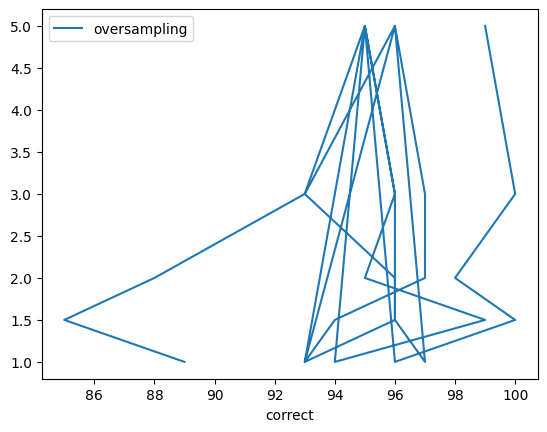

In [94]:
results_df[results_df["rescore"]].plot(y="oversampling", x="correct", kind="line")

In [13]:
# client.delete_collection(collection_name=f"{collection_name}")